### Classification with Rosenblatt's Perceptron

The "Hello World" of Machine Learning.

Recently the author was pondering what could be the most basic introduction to machine learning. He was after a simple task, such as binary classification, and of an algorithm that is sufficiently simple that it could be built from scratch and explained within a short article. If the algorithm had some history even better. It did not take much time to find the candidate: the perceptron. The perceptron takes us to the beginning of machine learning. It was introduced by Frank Rosenblatt more than 60 years ago. Like a neuron, the perceptron rule takes multiple input features and fits weights that when multiplied with the input feature vector allow taking a decision of whether the neuron outputs a signal or not, or in a machine learning classification context whether the output is 0 or 1. The perceptron is likely the simplest binary classifier and he is not aware of any practical machine learning use cases that could be tackled with it these days. However, it has significant education and historical value as it paved the way to neural networks. 

The purpose of this article is to introduce the perceptron and use it in a simple binary classification task. The perceptron has been implemented in scikit-learn but instead of relying on this we will built it from scratch. We will also create a set of visualisations to understand how the algorithm sets its decision boundary and peak into its convergence. The perceptron is a linear model comprising weights and a bias term that are simultaneously and iteratively adjusted during the fitting process. However, it does not have a continuous loss function likes perhaps immediate successor in the history of machine learning, the **adaptive neuron (Adaline)** algorithm that is also a single layered neural network. Fitting the perceptron simply relies on detecting misclassified samples, and the weights and bias are updated immediately as soon as a misclassified sample occurs and not once per epoch (epoch being a full pass through the training set). Hence, the algorithm does not even need an optimiser. He would dare to say that is so simple and elegant that it becomes beautiful. If I am curious to see how it works I would stay tuned definitely!

### Perceptron theory

The perceptron, like other linear models, uses a set of weights, one for each of the features, and to generate a prediction it computes the dot product of the weights and the feature values and adds a bias:

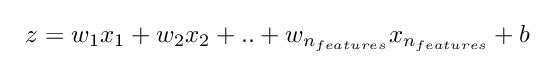

The result of this linear function, that is also known as net input, is fed into an activation function f(z) that in the case of the perceptron is a simple step function, i.e. f(z) takes the value of 1 if z>=0 and 0 otherwise. The role of the activation function is to map the net input to two values, namely 0 and 1. Essentially what we have done is nothing more than defining a hyperplane. Points that are at the same side of the hyperplane belong to the same class. The weights define the vector verticle to the hyperplane i.e the orientation of the hyperplane, and the bias the distance of the hyperplane from the origin. When the fitting process starts we have a randomly oriented hyperplane at a random distance from the origin. Whenever we encounter a misclassified sample we nudge the hyperplane a little bit and change its orientation and position so that in the next epoch the sample is at the right side of the hyperplane. We can decide how much to nudge the hyperplane, i.e what the learning rate should be.

Usually we need to pass through all samples a few times (epochs) until no point is misclassified, or to be more precise until no more progress can be made. In every epoch we loop over all samples i=1,...,n_samples in the training set and using the current weights and bias we examine if the model misclassifies and if it does update all weights j=1,..,n_features using a learning rate n (eta):

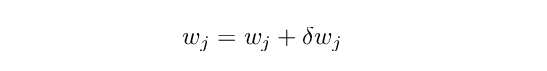 <br>
where <br>
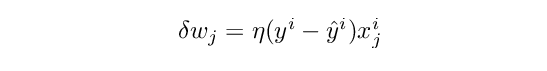 <br>
with hat indicating the prediction output. We also update this bias with <br>
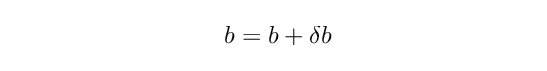 <br>
where <br>
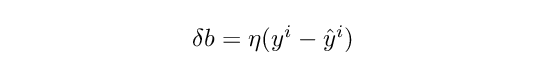

It is concentually easy to see why we do these operations. Assume that the model predicts class 0, while the correct one is 1. If xⱼ is positive, then the weight will be increased so that the net input increases. If xⱼ is negative, then the weight will be reduced so that the net input once more increases (regardless of the sign of the weight). Similarly the bias will be increased leading to further increases of the net input. With these changes it is more likely to predict the correct class for the misclassified sample in the next epoch. The logic is similar when the model predicts class 1, whilst the correct one is 0, with the only difference that all signs are inverted. 

If we notice carefully, the weights and bias may be updated multiple times within the same epoch, once for every misclassified sample. Every misclassification reorients and repositions the decision boundary hyperplane so the sample is correctly predicted in the next epoch. 

### Data Preparation

We will be using a synthetic dataset comprising two Gaussian distributions. The perceptron can be used with features of any dimension but for the purpose of this article we will limit ourselves to two dimensions to facilitate visualisation.

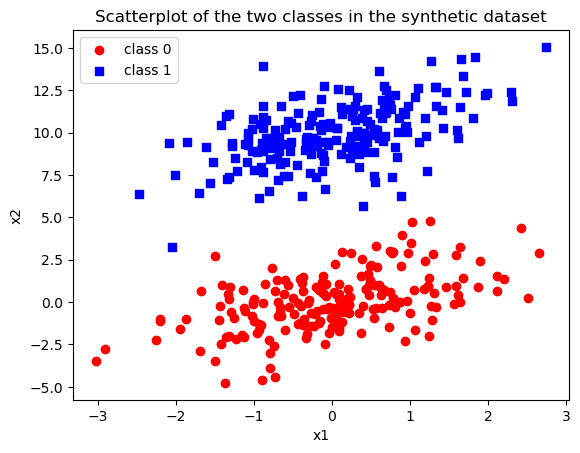

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# synthetic dataset with two Gaussian distributions
gen = np.random.RandomState(1)
mean1, cov1 = [0,0], [[1,1], [1,3]]
mean2, cov2 = [0,10], [[1,1], [1,3]]
n_samples = 400

X,y = pd.DataFrame(np.vstack([np.random.multivariate_normal(mean1, cov1, size=int(n_samples/2)),
                             np.random.multivariate_normal(mean2, cov2, size=int(n_samples/2))]),
                            columns=['x1','x2']), pd.Series([0]*int(n_samples/2)+[1]*int(n_samples/2), name='target')

fig = plt.figure()
ax = fig.subplots()
ax.scatter(X.loc[y==0, 'x1'], X.loc[y==0,'x2'], color='red', marker='o', label='class 0')
ax.scatter(X.loc[y==1, 'x1'], X.loc[y==1, 'x2'], color='blue', marker='s', label='class 1')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend(loc='upper left')
ax.set_title('Scatterplot of the two classes in the synthetic dataset');

The two guassian distributions are elongated and put further apart on purpose by choosing appropriate means and covariances. We will come back to this later. 

### Perceptron Implementation and Use

The implementation of the perceptron can be found below. We use the scikit-learn style to initiate the model, fit it and finally run a prediction. 

In [2]:
class Perceptron:
    def __init__(self, learning_rate=0.1, n_iterations=50, random_state=1):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.random_state = random_state
        
    def fit(self, X, y):
        # initiate the weights
        gen = np.random.RandomState(self.random_state)
        self.w_ = gen.uniform(low=0.01, high=0.05, size=X.shape[1])
        self.b_ = float(0.)
        self.n_misclassifications_ = []
        
        for _ in range(self.n_iterations):
            n_misclassifications = 0
            for xi, yi in zip(X,y): # this loop signifies one epoch
                yi_hat = self.predict(xi)
                move = self.learning_rate * (yi - yi_hat)
                # update the weights and bias
                self.w_ += move*xi
                self.b_ += move
                n_misclassifications += int(np.abs(move)>0)
            self.n_misclassifications_.append(n_misclassifications)
            if n_misclassifications == 0:
                break
             
    def predict(self, x):
        return np.where(np.dot(x, self.w_) + self.b_ >= 0., 1, 0)

The initialisation method sets the learning rate, the maximum number of iterations and the random number generator seed for reproducibility purposes. The fit method creates a random number generator that is then used to set the weights to some small numbers sampled from a uniform distribution, whilst the bias is initialised to zero. We then iterate for a maximum number of epochs. For every epoch we count the number of misclassifications so that we can monitor convergence and terminate early if possible. For every sample that is misclassified we update the weights and bias as described in the previous section. If the number of misclassifications is zero then no further improvements can be made and hence there is no need to continue with the next epoch. The predict method is simply computing the dot product of the weights and feature values , adds the bias and applies the step function. 

If we use the above perceptron class with the synthetic dataset:

weights and bias [-0.00592669  0.00688109], -0.03000000000000002


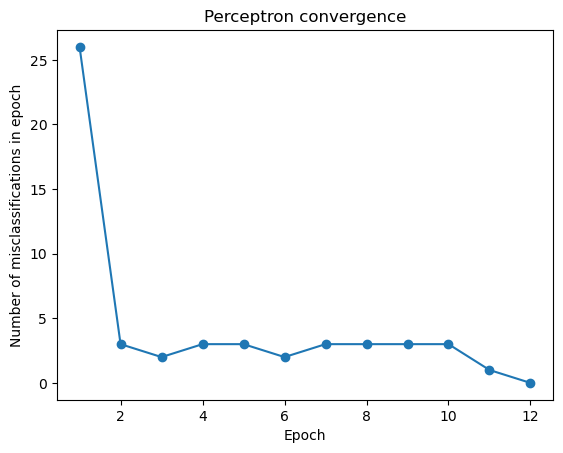

In [3]:
# fit the model
clf = Perceptron(learning_rate=0.001, n_iterations=30, random_state=1)
clf.fit(X.to_numpy(), y.to_numpy())

# visualize the convergence
fig = plt.figure()
ax = fig.subplots()
ax.plot(range(1, len(clf.n_misclassifications_)+1), clf.n_misclassifications_, marker='o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Number of misclassifications in epoch')
ax.set_title('Perceptron convergence')
print(f'weights and bias {clf.w_}, {clf.b_}')

The decision boundary can be readily visualized using the decision boundary utility function from scikit-learn. In order to use this function we generate a grid of 200x200 points spanning the range of feature values in the training set. Essentially we construct a contour plot with the predicted class and overlay the samples as a scatterplot coloured using the true labels. This way of plotting the decision boundary is quite generic and can be useful with any two dimensional classifier. 

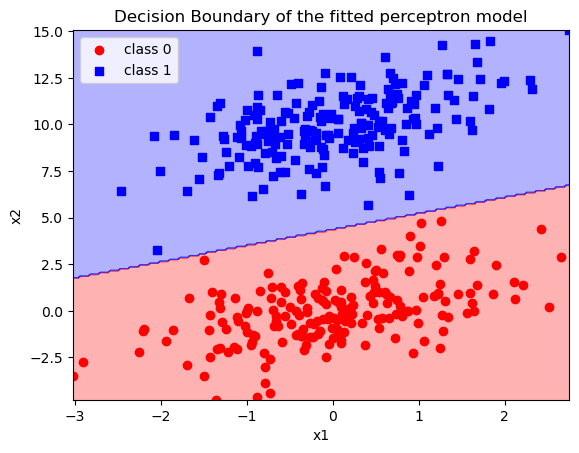

In [4]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

colors = ['red', 'blue']

cmap = ListedColormap(colors[:len(np.unique(y))])

x1, x2 = np.meshgrid(
    np.linspace(X.iloc[:,0].min(), X.iloc[:,0].max(), num=200),
    np.linspace(X.iloc[:,1].min(), X.iloc[:,1].max(), num=200)
)
grid = np.vstack([x1.ravel(), x2.ravel()]).T
y_pred = np.reshape(clf.predict(grid), x1.shape)

fig = plt.figure()
ax = fig.subplots()
display = DecisionBoundaryDisplay(xx0=x1, xx1=x2, response=y_pred)
display.plot(ax=ax, plot_method='contourf', cmap=cmap, alpha=0.3)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.scatter(X.loc[y==0, 'x1'], X.loc[y==0, 'x2'], color='red', marker='o', label='class 0')
ax.scatter(X.loc[y==1, 'x1'], X.loc[y==1, 'x2'], color='blue', marker='s', label='class 1')
ax.legend(loc='upper left')
ax.set_title('Decision Boundary of the fitted perceptron model');

The two synthetically constructed Gaussian distributions have been perfectly separated using a model that could be coded from scratch in few lines of code. The simplicity and elegance of this method makes it brilliant introductory and motivational example for machine learning.

We can also visualize the evolution of the decision boundary in the different epochs by stopping the model fitting process prematurely. This can be practically done by fitting the model using an increased cutoff for the maximum number of epochs. For every attempt we use the weights and bias of the fitted (possibly non converged) model and plot the decision boundary as a line. The lines are annotated using the epoch number. This could have been implemented more elegantly using a warm start, but fitting the model is very quick and hence it is not worthwhile to have that additional complexity. 

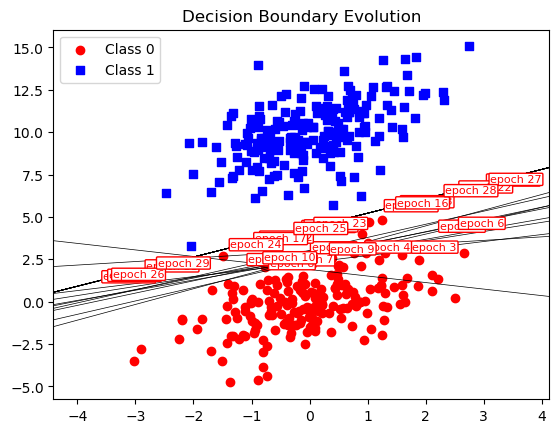

In [5]:
markers = ['o','s']
colors = ['red','blue']
fig = plt.figure()
ax = fig.subplots()
x1_min, x1_max = X['x1'].min() - 1, X['x1'].max() + 1
x2_min, x2_max = X['x2'].min() - 1, X['x2'].max() + 1
ax.scatter(X.loc[y==0, 'x1'], X.loc[y==0, 'x2'], c='red', marker='o', label=f'Class 0')
ax.scatter(X.loc[y==1, 'x1'], X.loc[y==1, 'x2'], c='blue', marker='s', label=f'Class 1')
ax.legend(loc='upper left')
ax.set_title('Decision Boundary Evolution')
for n_iter in range(1,30):
    clf = Perceptron(learning_rate=0.001, n_iterations=n_iter, random_state=1)
    clf.fit(X.to_numpy(), y.to_numpy())
    ln = ax.axline((x1_min, -(x1_min*clf.w_[0]+clf.b_)/clf.w_[1]), (x1_max, -(x1_max*clf.w_[0]+clf.b_)/clf.w_[1]), color='k', linewidth=0.5)
    rel_pos = np.random.uniform(0.05, 0.95)
    ax.annotate(str(f'epoch {n_iter}'), xy = (ln._xy1[0] + (ln._xy2[0]-ln._xy1[0])*rel_pos,
                                            ln._xy1[1] + (ln._xy2[1]-ln._xy1[1])*rel_pos),
                   color='red', fontsize=8,
                   bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.1'))

The decision boundary evolution for the various epochs is shown in the figure above. Initially, a small number of class 0 samples is misclassified, which causes gradual changes to the slope and intercept of the decision boundary line. We can see that convergence was achieved in 12 epochs, that is consistent with the convergence above. The fitting stops once the decision boundary achieves perfect separation of the classes, regardless of how close the boundary is to the samples in the vicinity.

A few notes of caution. Perceptron convergence cannot be taken for granted and for this reason it is important to set a maximum number of iterations. In fact, it can be proven mathematically that convergence is guranteed for linearly separable classes. If the classes are not linearly separable then the weights and bias will keep being updated until the maximum number of iterations is reached. This is why the two gaussians were moved further apart in the synthetic dataset. 

Another important note is that the perceptron has no unique solution. Typically there will be an infinite number of hyperplanes that can separate linearly separable classes and the model will randomly converge to one of them. This also means that measuring the distance from the decision boundary is not deterministic and hence not so useful. Support-vector machines address this limitation. 

The perceptron is essentially a single layer neural network. Understanding how it works is helpful before jumping to multi-layered neural networks and the backpropagation algorithm that can be used for non-linear problems. 